# Calcul d'effets prix avec données

Nous allons utiliser des données d'un restaurant de fast food. Ces données sont réparties en 3 fichiers. D'abord, il y a un fichier qui contient pour chaque journée le nombre de produit vendus, le prix moyen et le type de produit. Ce fichier est transactions.csv. Ensuite, un deuxième fichier contient les informations sur les produits, meta.csv et finalement un fichier contient les informations sur la date (température, etc). 

In [0]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

Il faudra prendre les fichiers partagées sur google drive... Il faudra créer un disque relié afin de les appeler de ce notebook. Voici comment faire: (on vous demandera un code d'authorisation, suivre le lien)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Mettre votre répertoire ici pour les notebooks du cours...

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/micro')

Voici le fichier des transactions

In [53]:
ts = pd.read_csv('sales/transactions.csv')
ts.head()

,STORE,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY
0,1,1/1/12,15.50,46,1070,0
1,1,1/1/12,12.73,22,2051,2
2,1,1/1/12,12.75,18,2052,2
3,1,1/1/12,12.60,30,2053,2
4,1,1/2/12,15.50,70,1070,0


Celui contenant les méta-données sur les produits

In [21]:
pr = pd.read_csv('sales/meta.csv')
pr.head()

,SELL_ID,SELL_CATEGORY,ITEM_ID,ITEM_NAME
0,1070,0,7821,BURGER
1,3055,0,3052,COFFEE
2,3067,0,5030,COKE
3,3028,0,6249,LEMONADE
4,2051,2,7821,BURGER


Et finalement celui contenant des informations sur la journée

In [22]:
da = pd.read_csv('sales/dates.csv')
da.head()

,CALENDAR_DATE,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1/1/12,2012,New Year,1,0,24.8,0
1,1/2/12,2012,New Year,0,0,24.8,0
2,1/3/12,2012,New Year,0,0,32.0,1
3,1/4/12,2012,NaN,0,0,32.0,1
4,1/5/12,2012,NaN,0,0,24.8,0


On crée une variable qui prend la valeur 1 si c'est un jour férié et 0 sinon. 

In [0]:
da['HOL'] = np.where(da['HOLIDAY'].isna()==False,1.0,0.0)

Nous allons nous concentrer sur les burgers vendu seuls. 

In [0]:
ts = ts[ts['SELL_ID']==1070]

Nous allons faire le merge avec le fichier de dates

In [0]:
df = ts.merge(da,on='CALENDAR_DATE')

Le prix varie dans le temps... 

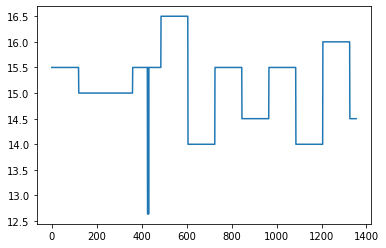

In [79]:
plt.figure()
plt.plot(df.index,df['PRICE'])
plt.show()

mais aussi la quantité...

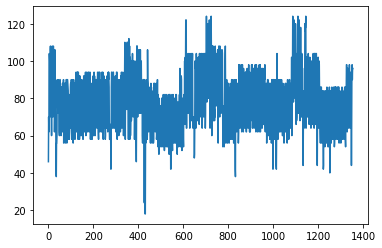

In [80]:
plt.figure()
plt.plot(df.index,df['QUANTITY'])
plt.show()

# Préférences et Demande des clients

Supposons que les consommateurs ont des préférences de type: 
$$ u(Q,M) = V(Q) + M $$

Et supposons que $V(Q) = \frac{e^{\alpha_0 + \alpha_1 Z + \epsilon} }{\alpha_Q}Q^{\alpha_Q} $ ou $Z$ est un vecteur décrivant le type de journée, $\epsilon$ est un terme de préférence inobservable. Avec ces préférences, la demande inverse des consommateurs est donnée par $P(Q) = e^{\alpha_0 + \alpha_1 Z + \epsilon} Q^{\alpha_Q-1}$.

On prend le log pour obtenir:

$$ \ln P(Q) = \alpha_0 + \alpha_1 Z + (\alpha_Q-1)\ln Q + \epsilon $$

La demande est donnée par:

$$ \ln Q(P) = \pi_0 + \pi_1 + \pi_P \ln P + \nu $$

ou $\pi_0 = \frac{\alpha_0}{\alpha_Q-1}$, $\pi_1 = \frac{\alpha_1}{\alpha_Q-1}$, $\pi_P = \frac{1}{\alpha_Q-1}$ et $\nu = \frac{1}{\alpha_Q-1}\epsilon$. 

L'elasicité prix est donnée par: 
$$ \frac{d\ln Q}{d\ln P} = \frac{dQ}{dP}\frac{P}{Q}  = \pi_P = \frac{1}{\alpha_Q-1} $$

Comment estimer la valeur de $\pi_P$? On peut utiliser les MCO (régression linéaire), si on suppose que $\nu$ n'est pas corrélé avec le prix et avec les $Z$. 

In [0]:
df['logQ'] = np.log(df['QUANTITY'])
df['logP'] = np.log(df['PRICE'])

On peut faire un modèle de régression:

In [87]:
import statsmodels.api as sm
vars = ['AVERAGE_TEMPERATURE','IS_WEEKEND','IS_SCHOOLBREAK','YEAR','HOL']
vars.append('logP')
X = df[vars].assign(const=1)
y = df['logQ']
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     647.2
Date:                Sun, 29 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:28:15   Log-Likelihood:                 1020.8
No. Observations:                1355   AIC:                            -2028.
Df Residuals:                    1348   BIC:                            -1991.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
AVERAGE_TEMPERATURE    -0.0018      0.000    -11.421      0.000      -0.002      -0.002
IS_WEEKEND             -0.3550      0.007    -51.586      0.000      -0.369      -0.342
IS_SCHOOLBREAK          0.0326      0.008      3.923      0.000       0.016       0.049
YEAR                    0.0009      0.003      0.289      0.773      -0.005       0.007
HOL                    -0.3521      0.012    -30.257      0.000      -0.375      -0.329
logP                   -0.9251      0.064    -14.561      0.000      -1.050      -0.800
const                   5.3256      6.216      0.857      0.392      -6.869      17.520
==============================================================================
Omnibus:                     2098.443   Durbin-Watson:                   1.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1109986.414
Skew:                          -9.291   Prob(JB):                         0.00
Kurtosis:                     141.978   Cond. No.                     4.04e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

L'élasticité prix est -0.925. C'est très prêt de -1. Pour ce qui est des autres variables, la température moyenne diminue la demande. La demande est plus forte les jours de semaines que le weekend (35% plus élevée). La demande est plus élevée les jours de congés d'école. Elle est plus faibles les jours fériés. 

In [90]:
pis = results.params

AVERAGE_TEMPERATURE   -0.001825
IS_WEEKEND            -0.355037
IS_SCHOOLBREAK         0.032599
YEAR                   0.000888
HOL                   -0.352114
logP                  -0.925136
const                  5.325565
dtype: float64

Le paramètres de la fonction d'utilité $\alpha_q$ est donnée par:

In [93]:
alpha_q = 1/pis['logP']+1
alpha_q

-0.08092166177774529

On peut déduire les autres:

In [0]:
alphas = []
for v in pis.index[:-2]:
  alphas.append(pis[v]*(alpha_q-1.0))
alphas.append(pis['const']*(alpha_q-1.0))
alphas.append(alpha_q)

On peut les mettre dans une belle liste...

In [0]:
parnames = ['alpha_1: temp','alpha_1: wkend','alpha_1: school','alpha_1: year','alpha_1: hol','alpha_0','alpha_q']

In [117]:
pd.DataFrame(index=parnames,data=alphas,columns=['estimate'])

,estimate
alpha_1: temp,0.001973
alpha_1: wkend,0.383768
alpha_1: school,-0.035237
alpha_1: year,-0.000960
alpha_1: hol,0.380608
alpha_0,-5.756518
alpha_q,-0.080922


Qu'est-ce qu'un gouvernement qui contemple une taxe sur la malbouffe peut faire avec cette information?